### **Deep Learning - Proyecto Final**

Stefano Aragoni, Carol Arévalo

----------

##### **Introducción**
El cyberbullying es una forma de acoso que se lleva a cabo a través de medios electrónicos, como las redes sociales. Este se caracteriza por ser –en su mayoría de instancias– anónimo y por la facilidad con la que los agresores pueden unirse y atacar a las víctimas. Es un problema grave que puede tener consecuencias emocionales y psicológicas significativas para quienes lo sufren. En realidad, según varios estudios, los adolescentes víctimas de ciberacoso son 4 veces más probables a tener pensamientos suicidas a comparación de aquellos que no reciben este tipo de acoso

En el presente trabajo se busca afrontar la problemática de ciberacoso en redes sociales a través de deep learning. Esto con el propósito de poder ayudar a la salud mental de aquellas personas que son víctimas de este tipo de violencia.

--------

##### **Análisis Exploratorio**

Para este proyecto, se utilizó un dataset presentado en la ‘Conferencia Internacional de Big Data’ en el 2020. Esta almacena tweets junto con una clasificación de los mismos para indicar si estos representan ciberacoso o no. A partir de esta base de datos, se realizó un análisis exploratorio. 

Como primer paso, se **importaron las librerías necesarias** para el análisis exploratorio y el preprocesamiento de los datos.



In [204]:
# Importaciones de bibliotecas estándar
import numpy as np
import pandas as pd
import re
from collections import Counter
from copy import deepcopy

# Importaciones de visualización
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas_profiling
from prettytable import PrettyTable

# Importaciones de procesamiento de texto y NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Importaciones de aprendizaje automático y ciencia de datos
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import SGD

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)

# Otras importaciones
from tqdm import tqdm
import pickle

Posteriormente, se **cargó el dataset** y se visualizaron las primeras 5 filas para tener una idea de la estructura de los datos.

Como se puede observar, el dataset cuenta con 2 columnas: 'tweet_text' y 'cyberbullying_type'. La primera almacena el texto del tweet y la segunda indica si este representa ciberacoso o no.

In [205]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets_clean.csv')

# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Asimismo, se quiso determinar la presencia de **valores nulos o vacíos en el dataset**. Para ello, se utilizó la función 'isnull()' y se sumaron los valores nulos por columna. Como se puede observar, no existen valores nulos en el dataset.

In [206]:
# Determinar valores nulos o faltantes
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

Asimismo, cabe destacar que se quiso determinar si habían **datos dupllicados**. Para ello, se utilizó la función 'duplicated()' y se sumaron los valores duplicados por columna. En este caso, s´i se encontraron datos duplicados. Por ello, se procedió a eliminarlos.

In [207]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
print("Número de datos duplicados: ", data.duplicated().sum())

#eliminar datos duplicados
data.drop_duplicates(inplace=True)

#verificar datos duplicados
print("Número de datos duplicados (post-limpieza): ", data.duplicated().sum())

Número de datos duplicados:  59
Número de datos duplicados (post-limpieza):  0


Con eso listo, se procedió a **visualizar la cantidad de tweets que representan ciberacoso y los que no**. 


Como se puede observar a continuación, pareciera que el dataset está balanceado. Esto debido a que cada clase cuenta con una cantidad similar de tweets. 

Sin embargo, religion, age, gender, ethnicity combinados representan el 80% de los tweets. Por tal motivo, al verlo como dos clases (cyberbullying y no cyberbullying) se puede observar que el dataset está desbalanceado. Esto debido a que la clase cyberbullying representa el 20% de los tweets, mientras que la clase no cyberbullying representa el 80% de los tweets.

religion             7994
age                  7979
ethnicity            7953
gender               7947
not_cyberbullying    7937
Name: cyberbullying_type, dtype: int64


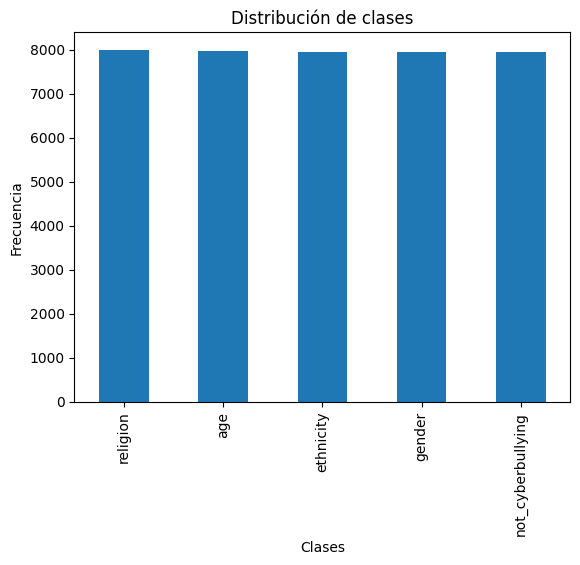

In [208]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

# Visualizar la distribución de clases
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Distribución de clases')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.show()

----------

##### **Preprocesamiento de Datos**

Para obtener datos más limpios se eliminaron hipervínculos, etiquetas y menciones de los comentarios. Asimismo, se eliminaron palabras vacías del idioma inglés que no aportan ninguna información relevante al modelo. En base a esto, se analizó cuáles eran las palabras más comunes en la base de datos. 

In [209]:
# Remover URLs, menciones y hashtags
new_tweets = []
new_types = []

def remove_urls_mentions_hashtags(text, type):
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', '', text) # Hashtags

    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub('[^a-zA-Z]', ' ', text) # Puntuación y números

    stemmer = PorterStemmer()
    text = text.split()
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)

    return text, type

for i in tqdm(range(len(data))):
    try:
        text, type = remove_urls_mentions_hashtags(data['tweet_text'][i], data['cyberbullying_type'][i])
        new_tweets.append(text)
        new_types.append(type)
    except:
        pass

data = pd.DataFrame({
    'tweet_text': new_tweets,
    'cyberbullying_type': new_types
})

  0%|          | 0/39810 [00:00<?, ?it/s]

100%|██████████| 39810/39810 [00:18<00:00, 2095.89it/s]


Después de haber realizado la limpieza de los tweets, se procedió a analizar **cuáles eran las palabras más comunes** en la base de datos. Para ello, se utilizó la función 'most_common()' de la librería 'collections'.

Como se puede observar, insultos y palabras ofensivas son las palabras más comunes en el dataset.

In [210]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

frecuencia = Counter(words).most_common(10)

table = PrettyTable()
table.field_names = ['Palabra', 'Frecuencia']
for i in range(len(frecuencia)):
    table.add_row([frecuencia[i][0], frecuencia[i][1]])

print(table)


+---------+------------+
| Palabra | Frecuencia |
+---------+------------+
|   the   |   28545    |
|    a    |   22473    |
|    i    |   22056    |
|    to   |   20935    |
|   and   |   20437    |
|   you   |   18906    |
|    in   |   13996    |
|    of   |   13993    |
|    is   |   12641    |
|   that  |   11788    |
+---------+------------+


Asimismo, se procedió a **visualizar las palabras más comunes en los tweets que representan ciberacoso**. Nuevamente, insultos y palabras ofensivas son las palabras más comunes en el dataset.

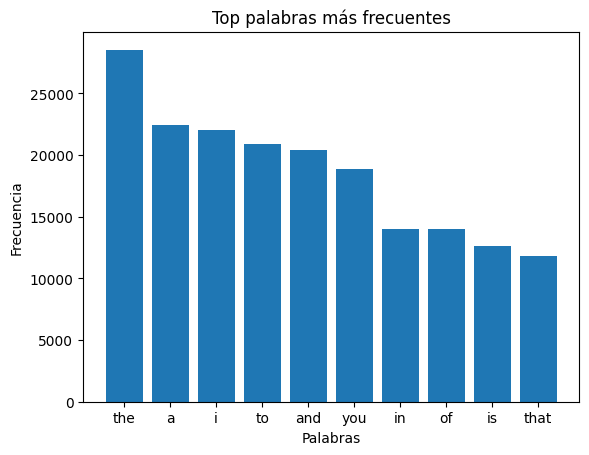

In [211]:
# Visualizar las palabras más frecuentes
plt.bar(*zip(*frecuencia))
plt.title('Top palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

Finalmente, se prosiguió a **encodear las etiquetas de los tweets**. Para ello, se utilizó la función 'LabelEncoder()' de la librería 'sklearn'.

In [212]:
# Encodificar las clases
label_encoder = LabelEncoder()
data['cyberbullying_type'] = label_encoder.fit_transform(data['cyberbullying_type'])

# Imprimir las clases y sus respectivos códigos
print('Clases:', label_encoder.classes_)
print('Códigos:', label_encoder.transform(label_encoder.classes_))


Clases: ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']
Códigos: [0 1 2 3 4]


In [213]:
data.head(10)

,tweet_text,cyberbullying_type
0,in other word your food wa crapilici,3
1,whi is so white,3
2,a classi whore or more red velvet cupcak,3
3,meh p thank for the head up but not too concer...,3
4,thi is an isi account pretend to be a kurdish ...,3
5,ye the test of god is that good or bad or indi...,3
6,itu sekolah ya bukan tempat bulli ga jauh kaya...,3
7,karma i hope it bite kat on the butt she is ju...,3
8,everyth but mostli my priest,3
9,rebecca black drop out of school due to bulli,3


-----------

##### **Preparación de Modelos**

Para este proyecto, se crearon 2 modelos diferentes.

El primer modelo es un modelo de **clasificación binaria**. Este modelo tiene como objetivo clasificar los tweets en 2 clases: cyberbullying y no cyberbullying. Para ello, se utilizó la columna 'cyberbullying_type' del dataset.

El segundo modelo se centra en **detectar el tipo de ciberacoso** presente, considerando la edad, género, religión y etnia como posibles categorías.


Se busca crear 2 modelos para pasarle al primero un tweet y que este nos diga si representa ciberacoso o no. En caso de que el tweet represente ciberacoso, se le pasará al segundo modelo para que nos diga qué tipo de ciberacoso es.

In [214]:
modelo1 = data.__deepcopy__()
modelo2 = data.__deepcopy__()

# Modelo 1: Cyberbullying vs. Not Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
not_cyberbullying = modelo1[modelo1['cyberbullying_type'] == 3]
age = modelo1[modelo1['cyberbullying_type'] == 0]
ethnicity = modelo1[modelo1['cyberbullying_type'] == 1]
gender = modelo1[modelo1['cyberbullying_type'] == 2]
religion = modelo1[modelo1['cyberbullying_type'] == 4]

sample_size = int(len(not_cyberbullying)/4)
sampled_age = age.sample(n=sample_size, replace=True, random_state=42)
sampled_gender = gender.sample(n=sample_size, replace=True, random_state=42)
sampled_religion = religion.sample(n=sample_size, replace=True, random_state=42)
sampled_ethnicity = ethnicity.sample(n=sample_size, replace=True, random_state=42)

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo1 = pd.concat([not_cyberbullying, sampled_gender, sampled_age, sampled_ethnicity, sampled_religion])

# Remplazar label age, gender, religion, ethnicity por 1
modelo1['cyberbullying_type'] = modelo1['cyberbullying_type'].replace([0, 1, 2, 4], 1)

# Remplazar label not_cyberbullying por 0
modelo1['cyberbullying_type'] = modelo1['cyberbullying_type'].replace([3], 0)

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo1['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 1: Cyberbullying vs. Not Cyberbullying\n")
print(frecuencias)


Modelo 1: Cyberbullying vs. Not Cyberbullying

0    7937
1    7936
Name: cyberbullying_type, dtype: int64


In [215]:
# Modelo 2: Tipos de Cyberbullying

# Separate `not_cyberbullying` and `cyberbullying` data
age = modelo2[modelo2['cyberbullying_type'] == 0]
gender = modelo2[modelo2['cyberbullying_type'] == 2]
religion = modelo2[modelo2['cyberbullying_type'] == 3]
ethnicity = modelo2[modelo2['cyberbullying_type'] == 1]

# Combine `sampled_cyberbullying` and `not_cyberbullying` data to create a new balanced dataframe
modelo2 = pd.concat([gender, age, ethnicity, religion])

# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = modelo2['cyberbullying_type'].value_counts()

# Mostrar los resultados
print("\nModelo 2: Cyberbullying Type\n")
print(frecuencias)


Modelo 2: Cyberbullying Type

0    7979
2    7947
3    7937
1    7894
Name: cyberbullying_type, dtype: int64


Con los dos datasets creados, se procedió a **dividirlos en datos de entrenamiento y datos de prueba**. Para ello, se utilizó la función 'train_test_split()' de la librería 'sklearn.model_selection'.

Asimismo, cabe destacar que se tokenizaron los tweets para poder alimentar los modelos. Para ello, se utilizó la función 'Tokenizer()' de la librería 'keras.preprocessing.text'.

In [216]:
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(modelo1['tweet_text'], modelo1['cyberbullying_type'], test_size=0.2, random_state=42)

X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(modelo2['tweet_text'], modelo2['cyberbullying_type'], test_size=0.2, random_state=42)

In [217]:
# Tokenización de texto de Modelo 1
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(X_train_m1)
X_train_sequences_m1 = tokenizer1.texts_to_sequences(X_train_m1)
X_valid_sequences_m1 = tokenizer1.texts_to_sequences(X_test_m1)

# Tokenización de texto de Modelo 2
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train_m2)
X_train_sequences_m2 = tokenizer2.texts_to_sequences(X_train_m2)
X_valid_sequences_m2 = tokenizer2.texts_to_sequences(X_test_m2)

Posteriormente, se secuenció y rellenó los diferentes comentarios para que todos tengan una longitud uniforme. En este caso se utilizó una longitud 200.

sequence.pad_sequences es una función de Keras que se utiliza para rellenar las secuencias. Si se pasa del largo máximo, se trunca la secuencia. Si es menor, se rellena con ceros.

In [218]:
# Padding de secuencias para que tengan la misma longitud
max_length = 250  # longitud máxima de una secuencia

X_train_m1_padded = pad_sequences(X_train_sequences_m1, maxlen=max_length)
X_valid_m1_padded = pad_sequences(X_valid_sequences_m1, maxlen=max_length)

X_train_m2_padded = pad_sequences(X_train_sequences_m2, maxlen=max_length)
X_valid_m2_padded = pad_sequences(X_valid_sequences_m2, maxlen=max_length)

-----------

##### **Diseño y Entrenamiento de Modelos**


Cuando ya se tenía los datos de entrenamiento y prueba, se procedió a **diseñar y entrenar el primer modelo**. Para ello, se utilizó la función 'Sequential()' de la librería 'keras.models'.

In [219]:
# ---------------------- Modelo 1 ----------------------

# Crear modelo
model1_lstm = Sequential()
model1_lstm.add(Embedding(len(tokenizer1.word_index)+1, 32, input_length=max_length))
model1_lstm.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model1_lstm.add(Dense(1, activation='sigmoid'))

# Compilar modelo
model1_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Entrenar modelo
model1_lstm.fit(X_train_m1_padded, y_train_m1, batch_size=16, epochs=10, validation_data=(X_valid_m1_padded, y_test_m1), callbacks=[early_stopping])

# Resultados de entrenamiento
loss, accuracy = model1_lstm.evaluate(X_valid_m1_padded, y_test_m1, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/10
794/794 [==============================] - 166s 204ms/step - loss: 0.2810 - accuracy: 0.8845 - val_loss: 0.2213 - val_accuracy: 0.9172
Epoch 2/10
794/794 [==============================] - 161s 203ms/step - loss: 0.1697 - accuracy: 0.9392 - val_loss: 0.2234 - val_accuracy: 0.9169
Test Loss: 0.22133037447929382, Test Accuracy: 0.9171653389930725


In [220]:
# ---------------------- Modelo 2 ----------------------

# Crear modelo
model2_lstm = Sequential()
model2_lstm.add(Embedding(len(tokenizer2.word_index)+1, 32, input_length=max_length))
model2_lstm.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model2_lstm.add(Dense(4, activation='softmax'))

# Compilar modelo
model2_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Entrenar modelo
model2_lstm.fit(X_train_m2_padded, y_train_m2, batch_size=16, epochs=10, validation_data=(X_valid_m2_padded, y_test_m2), callbacks=[early_stopping])

# Resultados de entrenamiento
loss, accuracy = model2_lstm.evaluate(X_valid_m2_padded, y_test_m2, verbose=False)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/10
1588/1588 [==============================] - 352s 218ms/step - loss: 0.3384 - accuracy: 0.8698 - val_loss: 0.2502 - val_accuracy: 0.9139
Epoch 2/10
1588/1588 [==============================] - 352s 221ms/step - loss: 0.1726 - accuracy: 0.9380 - val_loss: 0.2109 - val_accuracy: 0.9295
Epoch 3/10
1588/1588 [==============================] - 353s 222ms/step - loss: 0.1250 - accuracy: 0.9546 - val_loss: 0.2274 - val_accuracy: 0.9208
Test Loss: 0.21085071563720703, Test Accuracy: 0.9294710159301758


-----------

##### **Evaluación de Modelos**

Finalmente, se procedió a **evaluar los modelos**. Para ello, se utilizó classification_report de la librería 'sklearn.metrics'.

In [221]:
# ---------------------- Modelo 1 ----------------------

# classification report
y_pred_m1 = model1_lstm.predict(X_valid_m1_padded)
y_pred_m1 = np.round(y_pred_m1).astype(int)

print(classification_report(y_test_m1, y_pred_m1))

100/100 [==============================] - 4s 40ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1571
           1       0.96      0.88      0.91      1604

    accuracy                           0.92      3175
   macro avg       0.92      0.92      0.92      3175
weighted avg       0.92      0.92      0.92      3175



In [222]:
# ---------------------- Modelo 2 ----------------------

# classification report
y_pred_m2 = model2_lstm.predict(X_valid_m2_padded)
y_pred_m2 = np.argmax(y_pred_m2, axis=1)

print(classification_report(y_test_m2, y_pred_m2))

199/199 [==============================] - 8s 36ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1632
           1       0.99      0.97      0.98      1542
           2       0.91      0.87      0.89      1582
           3       0.85      0.89      0.87      1596

    accuracy                           0.93      6352
   macro avg       0.93      0.93      0.93      6352
weighted avg       0.93      0.93      0.93      6352

